In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g5b0a815229+07073039e0 	current w_2023_35 setup
alert_packet          gc1f99d08cb 	current w_2023_35 setup
analysis_drp          gfadca26dcd+7df23b908a 	current w_2023_35 setup
analysis_tools        g1887775915+12c68b5962 	current w_2023_35 setup
ap_association        g6758148a95+cc00875cc0 	current w_2023_35 setup
ap_pipe               g06c608b3b8+b6810408d8 	current w_2023_35 setup
ap_verify             g3bba7c13bf+c1b85e1378 	current w_2023_35 setup
astro_metadata_translator g0978aabd1f+2a7d2c9fe3 	current w_2023_35 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_35 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_35 setup
cbp                   ga32fcf49c8+ea6441928c 	current w_2023_35 setup
coadd_utils           g337abbeb29+ea6441928c 	current w_2023_35 setup
cp_pipe               g857a3418e4+7df23b908a 	current w_2023_35 setup
cp_verify       

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

# Paths 

In [10]:
outdir_base = 'output_fits/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_label = 'cyl_lens_flat_{0}/'

We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [13]:
obs_type = 'science'
obs_day = 20230912
physical_filter = 'cyl_lens~holo4_003' #Note that there are no exposure with this config for the moment 

In [14]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'expos','ra','dec','skyangle','science_program'])

In [15]:

where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}'".format(obs_type,obs_day,physical_filter)
#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1}".format(obs_type,obs_day)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023091200125
  physical_filter: 'cyl_lens~holo4_003'
  obs_id: 'AT_O_20230912_000125'
  exposure_time: 90.0
  dark_time: 90.2414
  observation_type: 'science'
  observation_reason: 'cyl_lens'
  day_obs: 20230912
  seq_num: 125
  seq_start: 125
  seq_end: 125
  group_name: '2023-09-12T23:45:36.165'
  group_id: 2744919361650000
  target_name: 'gam Gru'
  science_program: 'SITCOM-1009'
  tracking_ra: 328.47710063386694
  tracking_dec: -37.366563075205136
  sky_angle: 353.88281242076397
  azimuth: 113.56899044390968
  zenith_angle: 42.05053957893198
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-12 23:50:10.329008', scale='tai', format='iso'), end=astropy.time.Time('2023-09-12 23:51:40.570000', scale='tai', format='iso'))
	 timespan:             [2023-09-12T23:50:10.329008, 2023-09-12T23:51:40.570000)
	 timespan.begin:       2023-09-12 23:50:10.329008
	 id:                   2023091200125
	 day_obs:              202309

In [16]:
print('Number of entries = ',len(df_science))

Number of entries =  8


In [17]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
3,2023091200124,AT_O_20230912_000124,20230912,124,2023-09-12 23:48:57.140992,2023-09-12 23:49:57.369,science,gam Gru,cyl_lens~holo4_003,42.291929,60.0,328.477189,-37.367107,353.883300,SITCOM-1009
4,2023091200191,AT_O_20230912_000191,20230912,191,2023-09-13 01:15:44.897014,2023-09-13 01:16:15.135,science,zet Sgr,cyl_lens~holo4_003,11.916800,30.0,285.657805,-29.877593,185.161310,SITCOM-1009
5,2023091200194,AT_O_20230912_000194,20230912,194,2023-09-13 01:19:23.873014,2023-09-13 01:21:24.101,science,zet Sgr,cyl_lens~holo4_003,12.706693,120.0,285.657830,-29.877641,185.160992,SITCOM-1009
6,2023091200192,AT_O_20230912_000192,20230912,192,2023-09-13 01:16:27.910017,2023-09-13 01:17:28.150,science,zet Sgr,cyl_lens~holo4_003,12.075530,60.0,285.657790,-29.877591,185.161363,SITCOM-1009
7,2023091200193,AT_O_20230912_000193,20230912,193,2023-09-13 01:17:40.949010,2023-09-13 01:19:11.188,science,zet Sgr,cyl_lens~holo4_003,12.338790,90.0,285.657854,-29.877560,185.161400,SITCOM-1009


Select exposures: 

In [18]:
seq_nums = np.array(df_science.seq_num)
print(seq_nums)

[125 123 126 124 191 194 192 193]


We test retrieving one of them: 

In [19]:
seq_num0 = seq_nums[0]
exp_id0 = str(obs_day)+'00'+str(seq_num0)
exp_id0 = int(exp_id0)
print(exp_id0)

2023091200125


In [20]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

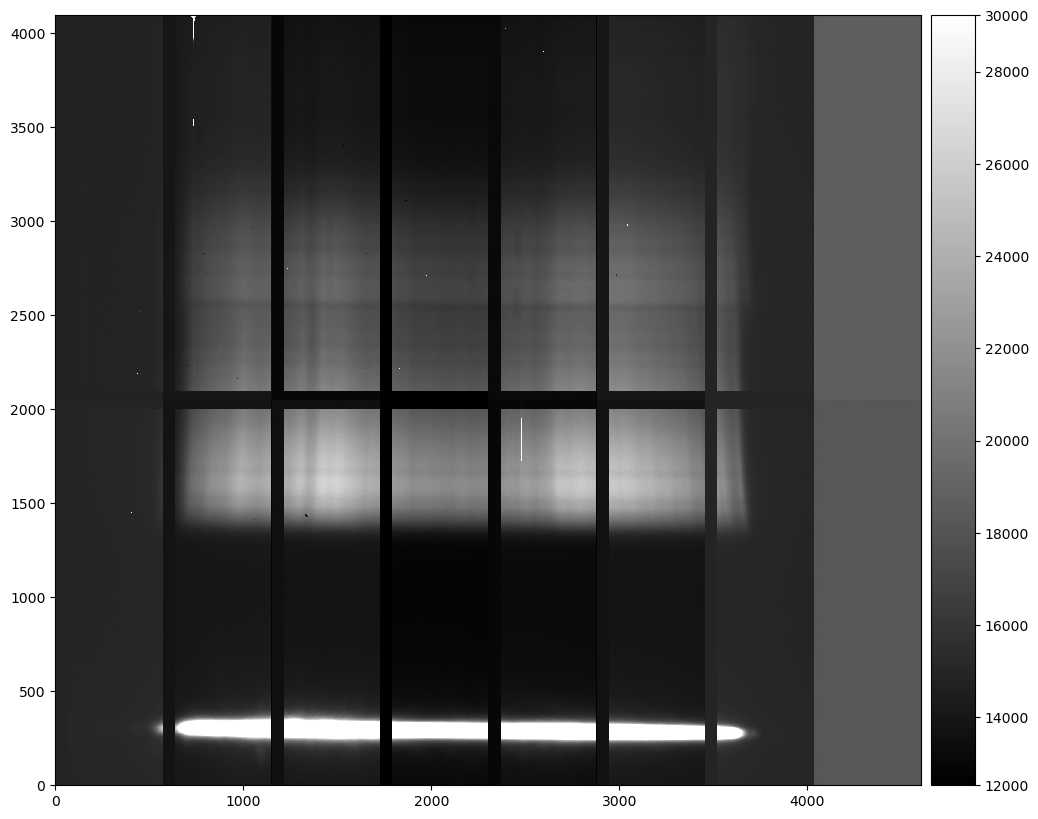

In [21]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [22]:
# configuration
isr_config =  IsrTaskConfig()

In [23]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [24]:
isr_task = IsrTask(config=isr_config)

In [25]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [26]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


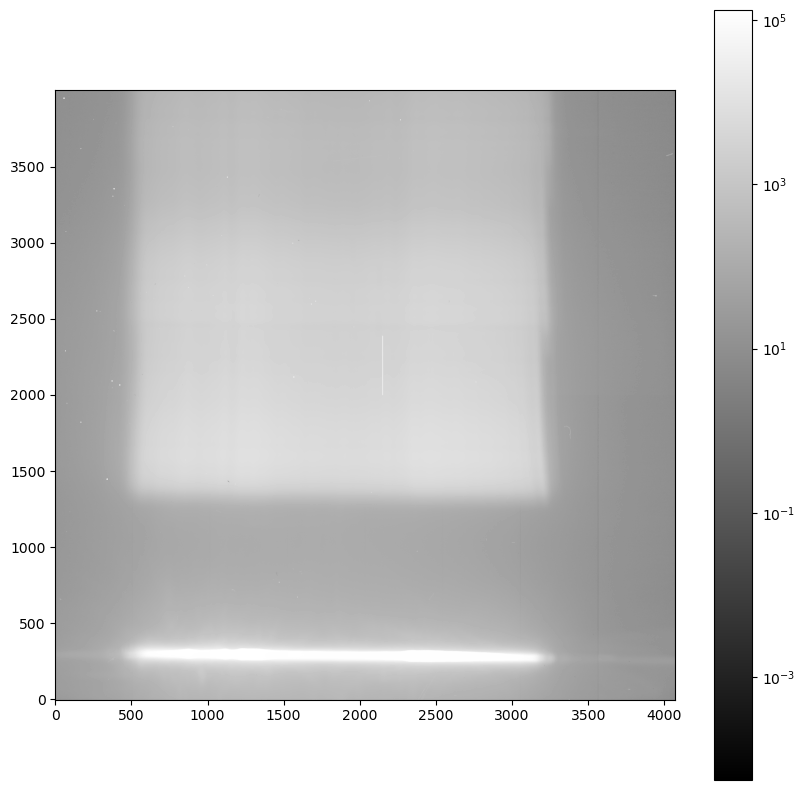

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)

# Create sum exposure from individual exposures 

## 1. Do pseudo-postISRCCD 

In [28]:
print(seq_nums)

[125 123 126 124 191 194 192 193]


In [29]:
exp_list = []
ampli_boxes = {}
ampli_names = []
for i,num_ in enumerate(seq_nums):
    exp_id_ = str(obs_day)+'00'+str(num_)
    exp_id_ = int(exp_id_)
    print(exp_id_)
    raw_img_ = butler.get('raw', dataId={'exposure': exp_id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    print('Raw image retrieved')
    
    bias_ = butler.get("bias",instrument=cameraName, exposure= exp_id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= exp_id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    print('Running pseudo-ISR')
    isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)
    
    exp_list.append(isr_img_)
    print('-----------------')
    
    if i==0:
        for ampIdx, amp in enumerate(raw_img_.getDetector()):
            ampli_name_ = amp.getName()
            ampli_names.append(ampli_name_)
            xbegin = amp.getBBox().x.begin
            xend = amp.getBBox().x.end
            ybegin = amp.getBBox().y.begin
            yend = amp.getBBox().y.end
            ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)
            
            md = raw_img_.getMetadata().toDict()
    

2023091200125
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200123
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200126
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200124
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200191
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200194
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200192
Raw image retrieved
Running pseudo-ISR


-----------------
2023091200193
Raw image retrieved
Running pseudo-ISR


-----------------


In [30]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

In [31]:
mapampid = [0,1,2,3,4,5,6,7,15,14,13,12,11,10,9,8]

In [32]:
num_amplis = len(mapampid)

## 2. Wavelength (row) normalization 

We test the normalization with one exposure 

In [33]:
exp0 = exp_list[0].exposure.image.array

In [34]:
print(exp0.shape)

(4000, 4072)


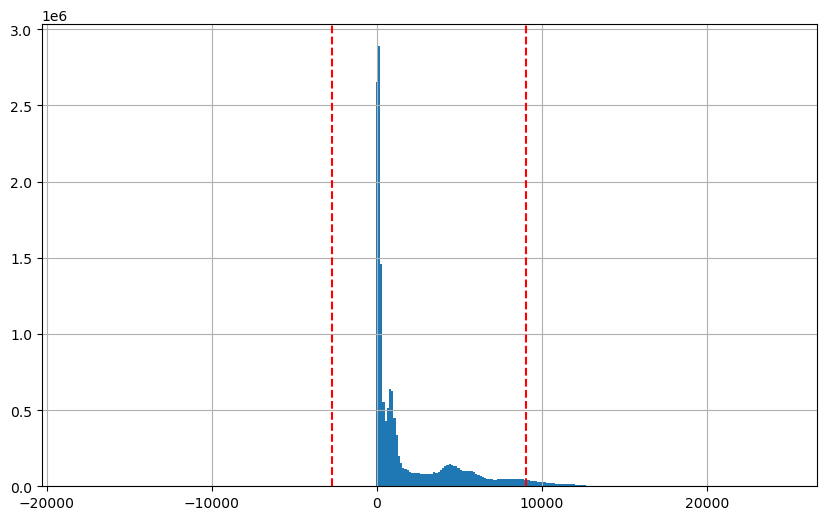

In [35]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
_ = ax.hist(exp0.flatten(),bins=1000)
mu = np.mean(exp0.flatten())
sigma = np.std(exp0.flatten())
nsigma = 0.5
ax.axvline(x=mu-nsigma*sigma,ls='--',color='r')
ax.axvline(x=mu+nsigma*sigma,ls='--',color='r')
ax.set_xlim(mu-2.*sigma,mu+2.*sigma)
ax.grid()

In [36]:
vmin = 1
vmax = 6000

(0.0, 4000.0)

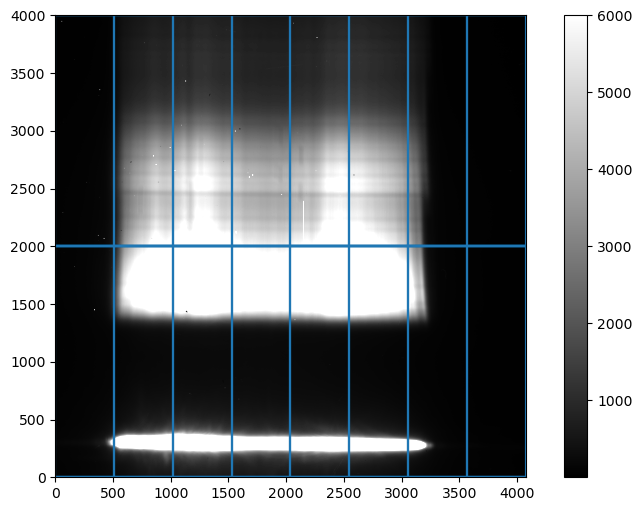

In [60]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
im = ax.imshow(exp0,cmap="gray",origin='lower',vmin=vmin,vmax=vmax)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
for key in ampli_boxes.keys():
    ax.axvline(x=ampli_boxes[key][0])
    ax.axvline(x=ampli_boxes[key][1])
    ax.axhline(y=ampli_boxes[key][2])
    ax.axhline(y=ampli_boxes[key][3])
ax.set_xlim(0,4072)
ax.set_ylim(0,4000)

Visualize data per amplifier separately 

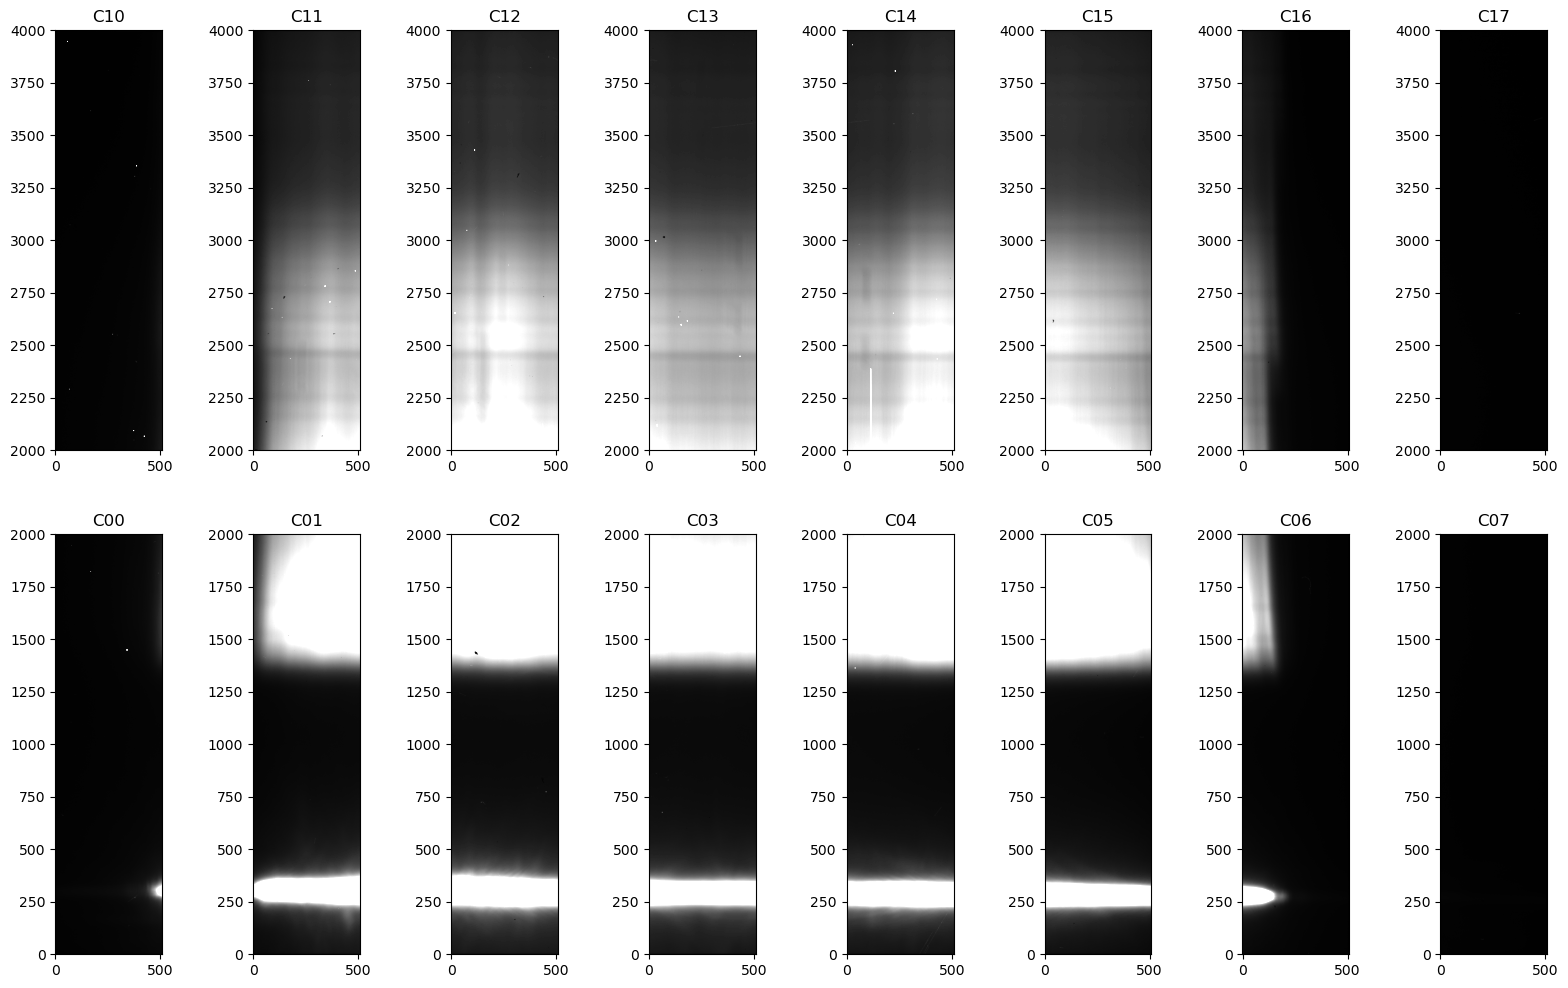

In [38]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = exp0[y0:y1,x0:x1]
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(ampli_,cmap="gray",origin='lower',vmin=vmin,vmax=vmax)#,norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)

We normalize each row (per amplifier) to their median value. This way, we can compare exposure with different number counts (due to different effective exposure times) 

(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)


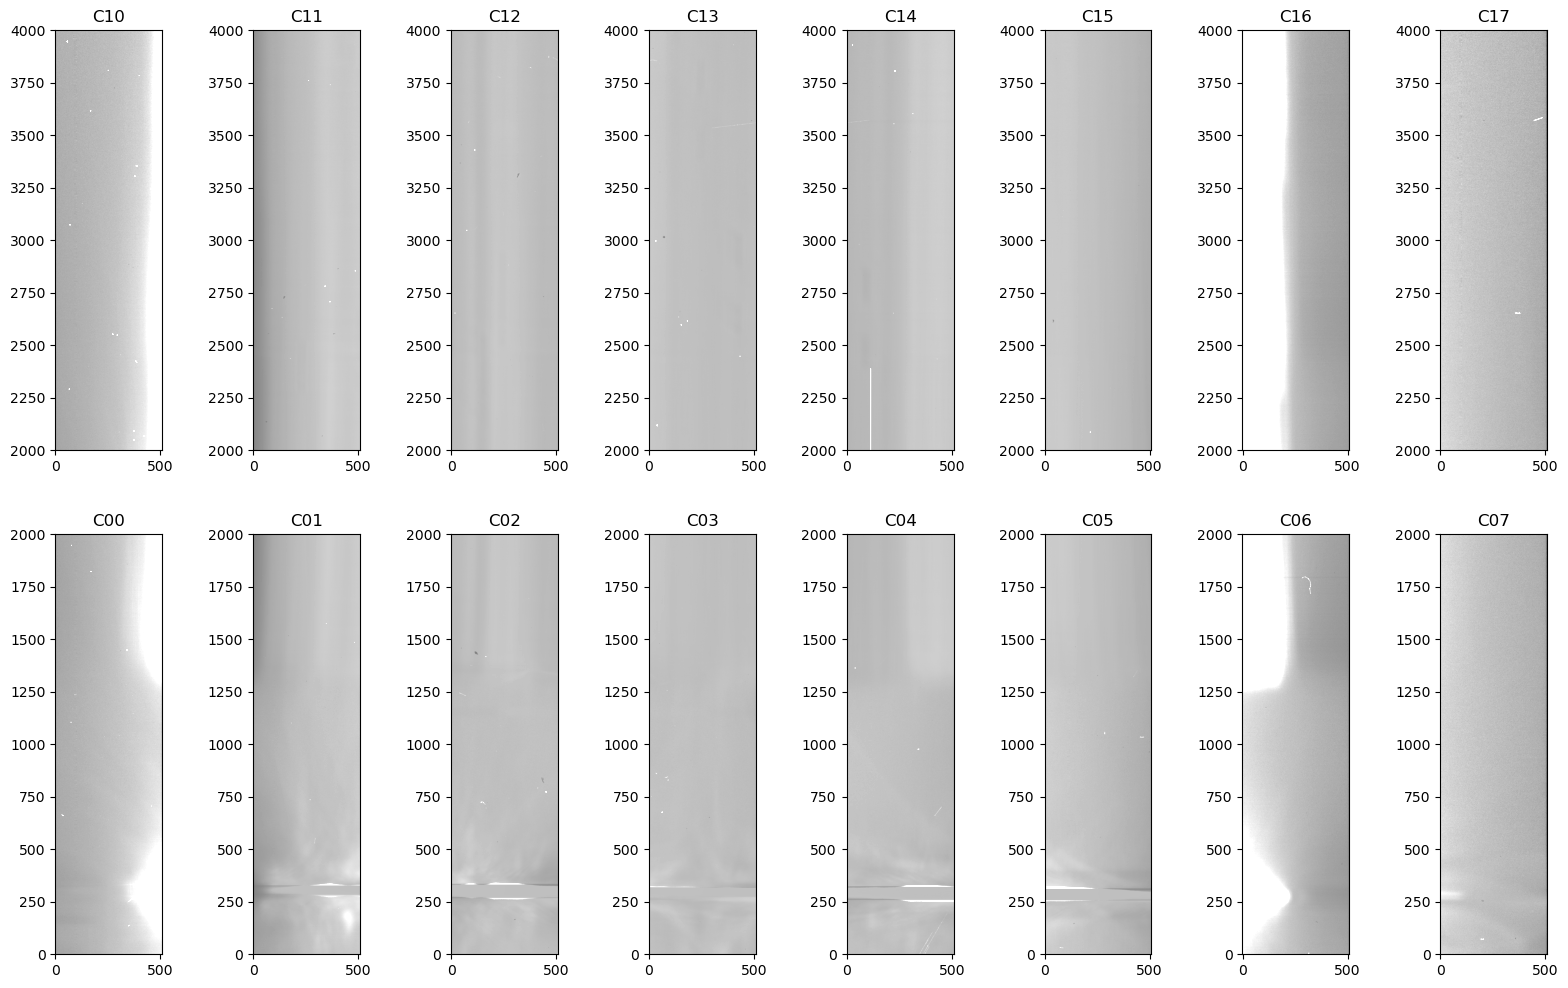

In [52]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = exp0[y0:y1,x0:x1]
    median_ = np.median(ampli_,axis=1)
    
    norm_ampli_ = ampli_/median_[:,None]
    print(norm_ampli_.shape)
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(norm_ampli_,cmap="gray",origin='lower',vmin=-2,vmax=2)#,norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)


Now we do this systematically for all exposures and we combine taking their median pixel by pixel 

In [40]:
print(len(exp_list))

8


In [41]:
special_flat_ = []
for i,exp_ in enumerate(exp_list):
    print(i)
    data_ = exp_.exposure.image.array
    print(data_.shape)
    
    out_ = np.zeros(data_.shape)
    for key in ampli_boxes.keys():
        x0 = ampli_boxes[key][0]
        x1 = ampli_boxes[key][1]
        y0 = ampli_boxes[key][2]
        y1 = ampli_boxes[key][3]
        ampli_ = data_[y0:y1,x0:x1]
        median_ = np.median(ampli_,axis=1)

        norm_ampli_ = ampli_/median_[:,None]
        print(norm_ampli_.shape)
        
        out_[y0:y1,x0:x1] = norm_ampli_
    print(out_.shape)
    special_flat_.append(out_)
    print('-------------')
special_flat_ = np.array(special_flat_)
print(special_flat_.shape)

0
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
1
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
2
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
3
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
4
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(

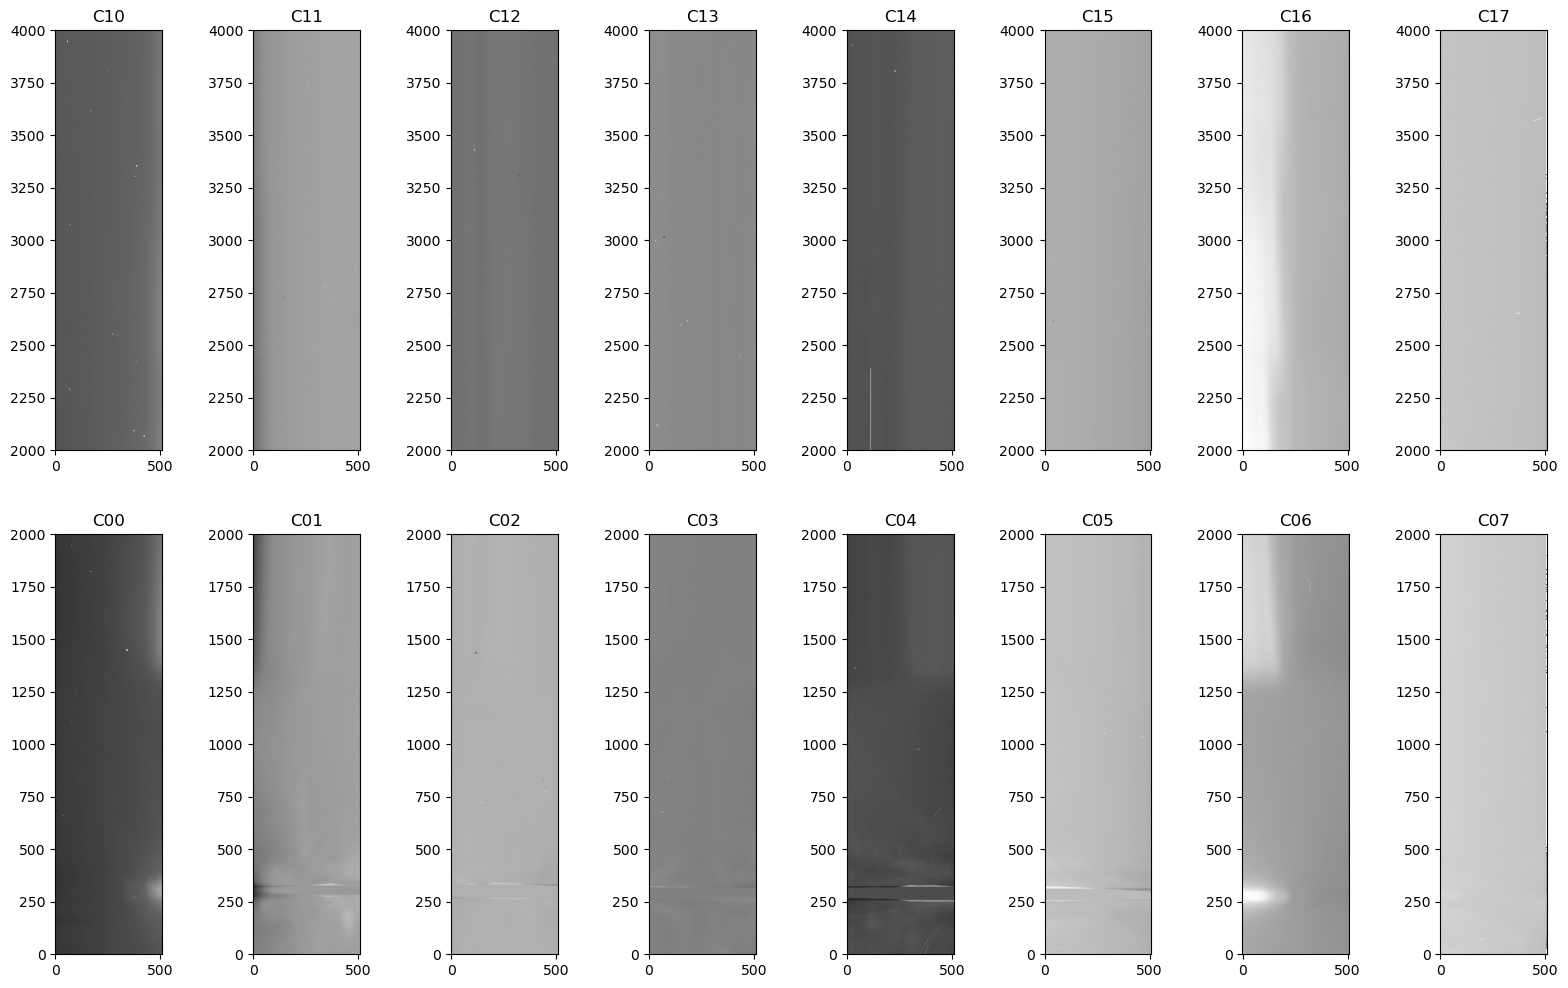

In [42]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = special_flat_[0][y0:y1,x0:x1]
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(ampli_,cmap="gray",origin='lower',norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)

## 3. Compute median of individual exposures and combine into one 

In [43]:
special_flat = np.median(special_flat_,axis=0)

In [44]:
print(special_flat.shape)

(4000, 4072)


(0.0, 4000.0)

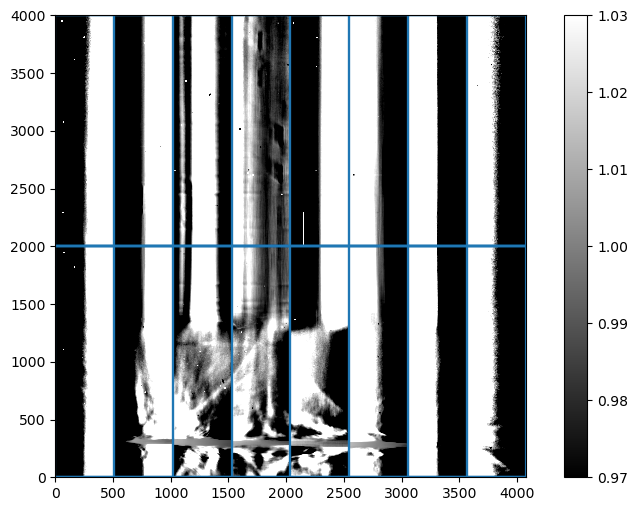

In [63]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
im = ax.imshow(special_flat,cmap="gray",origin='lower',vmin=0.97,vmax=1.03)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
for key in ampli_boxes.keys():
    ax.axvline(x=ampli_boxes[key][0])
    ax.axvline(x=ampli_boxes[key][1])
    ax.axhline(y=ampli_boxes[key][2])
    ax.axhline(y=ampli_boxes[key][3])
ax.set_xlim(0,4072)
ax.set_ylim(0,4000)

# Save in fits file 

In [46]:
outdir_ = outdir_label.format(obs_day)
outdir = os.path.join(outdir_base,outdir_)
if os.path.exists(outdir)==False:
    os.mkdir(outdir)

In [47]:
filename_out = 'cyl_lens_flat_{0}.fits'.format(obs_day)
fullfilename_out = os.path.join(outdir,filename_out)

print(f">>>>  output filename {filename_out}")

hdr = fits.Header()
    
for key,value in md.items():
    hdr[str(key)] = value
    

# Be carefull for Spectractor, 2 hdu units are necessary

primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(special_flat)

hdu_list = fits.HDUList([primary_hdu, image_hdu])

hdu_list.writeto(fullfilename_out,overwrite=True)

>>>>  output filename cyl_lens_flat_20230912.fits
